# Prediccion de complicaciones durante la hospitalizacion del paciente de infarto de miocardio


En este proyecto se va utilizar técnicas de aprendisaje automático para la predicción de posibles complicaciones en pacientes que fueron ingresados a un hospital por ataque al miocardio.

In [ ]:
import random
from collections import Counter
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import isnan
from numpy import mean
from numpy import std
from numpy import loadtxt
from numpy import sort
from matplotlib import pyplot
import matplotlib.pyplot as plt
import graphviz
from graphviz import Digraph
from sklearn import tree
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as skl_lm
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [7]:
dataframe = pd.read_csv("/content/drive/MyDrive/PUCP/Aprendizaje_automatico/machine/myocardial+infarction+complications/myocardial_dataset.csv", header=0, na_values='?')

Análisis de datos

In [8]:
print(dataframe.shape)

(1700, 112)


In [9]:
print(dataframe.dtypes.unique())

[dtype('float64') dtype('int64')]


In [10]:
print(dataframe.head())

    AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL   GB  \
0  77.0    1       2.0        1.0        1.0       2.0       NaN  3.0   
1  55.0    1       1.0        0.0        0.0       0.0       0.0  0.0   
2  52.0    1       0.0        0.0        0.0       2.0       NaN  2.0   
3  68.0    0       0.0        0.0        0.0       2.0       NaN  2.0   
4  60.0    1       0.0        0.0        0.0       2.0       NaN  3.0   

   SIM_GIPERT  DLIT_AG  ...  NOT_NA_2_n  NOT_NA_3_n  LID_S_n  B_BLOK_S_n  \
0         0.0      7.0  ...         0.0         0.0      1.0         0.0   
1         0.0      0.0  ...         0.0         0.0      1.0         0.0   
2         0.0      2.0  ...         2.0         2.0      1.0         1.0   
3         0.0      3.0  ...         0.0         0.0      0.0         0.0   
4         0.0      7.0  ...         0.0         0.0      0.0         0.0   

   ANT_CA_S_n  GEPAR_S_n  ASP_S_n  TIKL_S_n  TRENT_S_n  Compl  
0         0.0        1.0      1.0       

In [11]:
print(dataframe.describe())

               AGE          SEX     INF_ANAM    STENOK_AN    FK_STENOK  \
count  1692.000000  1700.000000  1696.000000  1594.000000  1627.000000   
mean     61.856974     0.626471     0.554835     2.316186     1.205286   
std      11.259936     0.483883     0.836801     2.440586     1.040814   
min      26.000000     0.000000     0.000000     0.000000     0.000000   
25%      54.000000     0.000000     0.000000     0.000000     0.000000   
50%      63.000000     1.000000     0.000000     1.000000     2.000000   
75%      70.000000     1.000000     1.000000     5.000000     2.000000   
max      92.000000     1.000000     3.000000     6.000000     4.000000   

          IBS_POST  IBS_NASL           GB   SIM_GIPERT      DLIT_AG  ...  \
count  1649.000000  72.00000  1691.000000  1692.000000  1452.000000  ...   
mean      1.160703   0.37500     1.393258     0.033688     3.340220  ...   
std       0.801400   0.48752     1.088803     0.180478     3.098646  ...   
min       0.000000   0.00000 

#Pre-procesamiento de los datos

**Manejo de datos faltantes**

Columnas con datos faltantes, se van a remover las columnas con mas de 30% de datos faltantes, como resultado 7 columnas y 24 filas se eliminaron.

In [12]:
# valores faltantes por columna (# umbral de: 30%)
column_list = []
for i in range(dataframe.shape[1]):
    n_miss = dataframe.iloc[:,i].isnull().sum()
    perc = n_miss / dataframe.shape[0] * 100
    # print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
    if perc >= 30:
        column_list.append(i)

In [13]:
# Se elimina filas con datos faltantes
dataframe_col_name = dataframe.columns
dataframe_col_name_delete= dataframe_col_name[column_list]
dataframe.drop(dataframe_col_name_delete, axis=1, inplace=True)

In [14]:
dataframe.to_csv('myocardial_dataset2.csv')
dataframe_2 = pd.read_csv("myocardial_dataset2.csv", index_col = 0, na_values='?')

In [15]:
# valores faltantes por columna (# umbral de: 30%)
row_list = []
for i in range(dataframe_2.shape[0]):
    n_miss = dataframe_2.iloc[i].isnull().sum()
    perc = n_miss / dataframe_2.shape[1] * 100
    # print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
    if perc >= 30:
        row_list.append(i)

In [16]:
dataframe_2.drop(row_list,axis=0,inplace=True)
dataframe_2.to_csv('myocardial_dataset3.csv')

In [17]:
X = dataframe_2.iloc[:, 0:104]
y = dataframe_2.iloc[:, 104]

In [18]:
# crea una lista de variables binarias
binary_list = []
for i in range(len(X.iloc[0])):
    if X.iloc[:,i].max() == 1:
        binary_list.append(i)

In [19]:
# crea una lista  de variables continuas
continuous_list = [0,32,33,79,81,82,83,84,85]

# crea un a lista de todas las variables
listt = [*range(104)]

In [20]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [21]:
# crea una lista de variables categ{oricas
binary_categorical = Diff(listt, continuous_list)
categorical_list = Diff(binary_categorical,binary_list)

In [22]:
# convierte binario a booleano
for i in range(len(X.columns[binary_list])):
    X[X.columns[binary_list][i]] = X[X.columns[binary_list][i]].astype('bool')
X[X.columns[binary_list]]
X_binary = X[X.columns[binary_list]]
binary_name = X_binary.columns

In [23]:
# se convierte de continuo a float
for i in range(len(X.columns[continuous_list])):
    X[X.columns[continuous_list][i]] = X[X.columns[continuous_list][i]].astype('float')
X[X.columns[continuous_list]]
X_continuous = X[X.columns[continuous_list]]
cont_name = X_continuous.columns

In [24]:
# Se convierte de categórico a entero
for i in range(len(X.columns[categorical_list])):
    X[X.columns[categorical_list][i]] = X[X.columns[categorical_list][i]].astype('float')
X[X.columns[categorical_list]]
X_categorical = X[X.columns[categorical_list]]
catg_name = X_categorical.columns

**Imputación de datos**

Los datos con menos de 30% de datos faltantes se va aplicar la imputación de datos por la estrategia de KNN.

In [28]:
#inputar variables binarias
imputer = KNNImputer(n_neighbors=5)
imputer=imputer.fit(X_binary)

# Se convierte a array
X_binary = imputer.transform(X_binary)
X_binary = pd.DataFrame(X_binary)
X_binary.columns = binary_name
X_binary.to_csv('Myocardial_binary.csv',sep=",")
# check null values
print("La suma total de todos los valores faltantes en X binario:", X_binary.isnull().sum(axis = 0).sum())

La suma total de todos los valores faltantes en X binario: 0


In [29]:
# imputación en variables continuas
imputer = KNNImputer(n_neighbors=5)
imputer=imputer.fit(X_continuous)

X_continuous = imputer.transform(X_continuous)
X_continuous = pd.DataFrame(X_continuous)
X_continuous.to_csv('Myocardial_cont.csv',sep=",")
X_continuous.columns = cont_name
print("La suma total de todos los valores faltantes en X continuo:", X_continuous.isnull().sum(axis = 0).sum())

La suma total de todos los valores faltantes en X continuo: 0


Para las variables categóricas se va usar la imputación de datos por moda.

In [30]:
# imputación de datos categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer=imputer.fit(X_categorical)

X_categorical = imputer.transform(X_categorical)
X_categorical = pd.DataFrame(X_categorical)
X_categorical.columns = catg_name
X_categorical.to_csv('myocardial_catg.csv',sep=",")
print("La suma total de todos los valores faltantes en X categorica:",X_categorical.isnull().sum(axis = 0).sum())

La suma total de todos los valores faltantes en X categorica: 0


In [31]:
# retorno de columnas en array
def column(matrix, i):
    return [row[i] for row in matrix]

**Imputación de datos con método One-Hot-Encoding**

Para mejorar la imputación de datos de tipo categórico se utiliza el método One-Hot Encoding

In [32]:
# codificación de variables categoricas
X_cat = X_categorical.to_numpy()
encoded_dataframe = pd.get_dummies(column(X_cat,0))

for i in range(1,len(X_categorical.iloc[0])):
    encoded = pd.get_dummies(column(X_cat,i))
    encoded_dataframe = pd.concat([encoded_dataframe, encoded], axis=1)

categorical_names = [*np.arange(101)]
encoded_dataframe.columns = categorical_names
encoded_dataframe.to_csv('myocardial_encoding.csv',sep=",")

**Normalización de datos**

Las variables continuas tienes diferentes escalas lo cual pude afectar al algoritmo de predicción, para lo cual se realiza la normalización de los datos.

In [33]:
# estandarización de variables continuas
for i in range(len(X_continuous.iloc[0])):
    X_continuous.iloc[:, i] = (X_continuous.iloc[:, i] - X_continuous.iloc[:, i].mean())/X_continuous.iloc[:, i].std()

# dataset combinados
X_all_combined = pd.concat([X_continuous, encoded_dataframe, X_binary], axis=1)
X_all_combined.to_csv('myocardial_2_v2.csv')
X_df = X_all_combined

**Entrenamiento y validación**

En el siguiente apartado se va dividir los datos en los conjuntos de entrenamiento y validación, mediantes muestreo estratificado y un cross-validation de k=10

In [34]:
counter = Counter(y)
print(counter)

Counter({1: 923, 0: 753})


In [35]:
random.seed(240)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify = y)

In [36]:
counter = Counter(y_train)
print(counter)

Counter({1: 738, 0: 602})


**METODOLOGÍA:**
**ARBOL DE DECISIÓN**

Eliminación de caraceterísticas recursivas

In [45]:
# Lista de modelos para evaluar
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluación con cross-validation
def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>2 0.513 (0.050)
>3 0.526 (0.043)
>4 0.531 (0.048)
>5 0.542 (0.040)
>6 0.535 (0.033)
>7 0.549 (0.043)
>8 0.539 (0.046)
>9 0.542 (0.040)
>10 0.561 (0.042)
>11 0.550 (0.040)
>12 0.559 (0.040)
>13 0.566 (0.035)
>14 0.567 (0.041)
>15 0.565 (0.045)
>16 0.565 (0.046)
>17 0.562 (0.042)
>18 0.564 (0.050)
>19 0.569 (0.044)
>20 0.572 (0.046)


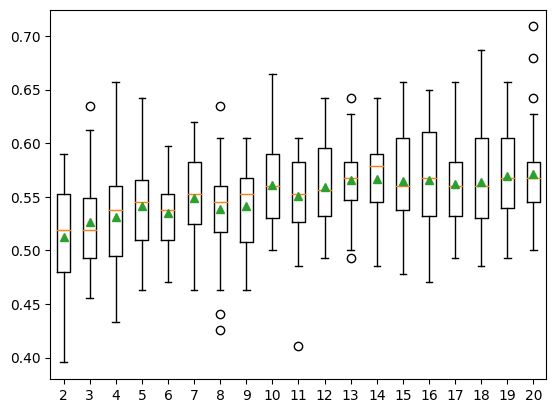

In [40]:
# se toma el modelo para evaluar
models = get_models()
X_train.columns = X_train.columns.map(str)

# evaluan modelos y se guardan los resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# grafica de resultados y comparación
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

RFE- Eliminación recursiva de caracteristicas

In [41]:
# 10 características
rfe_10 = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe_10.fit(X_train, y_train)

# reporte de características seleccionadas
for i in range(X_train.shape[1]):
    if(rfe_10.support_[i] == True):
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_10.support_[i], rfe_10.ranking_[i]))

# guardado de características seleccionadas
DT_selected_list_10 = []
for i in range(X_train.shape[1]):
    if rfe_10.support_[i] == True:
        DT_selected_list_10.append(i)
X_train.columns[DT_selected_list_10]
X_train_10 = X_train[X_train.columns[DT_selected_list_10]]

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 41, Selected True, Rank: 1.000


Ajuste de Hiperparámetros

In [42]:
# 10 características
param_test1 = {
 'max_depth':range(2,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(DecisionTreeClassifier(),param_test1)

grid.fit(X_train_10,y_train)
grid.best_params_, grid.best_score_

({'max_depth': 2, 'min_samples_leaf': 10}, 0.5977611940298508)

Predicción

In [46]:
# 10 características
X_test_10 = X_test[X_test.columns[DT_selected_list_10]]

clf_dt_10 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=10)
clf_dt_10 = clf_dt_10.fit(X_train_10,y_train)
y_pred = clf_dt_10.predict(X_test_10)

# reporte de métricas
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [47]:
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
        model = RandomForestClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()